In [2]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
def get_data(filename):
  # You will need to write code that will read the file passed
  # into this function. The first line contains the column headers
  # so you should ignore it
  # Each successive line contians 785 comma separated values between 0 and 255
  # The first value is the label
  # The rest are the pixel values for that picture
  # The function will return 2 np.array types. One with all the labels
  # One with all the images
  #
  # Tips: 
  # If you read a full line (as 'row') then row[0] has the label
  # and row[1:785] has the 784 pixel values
  # Take a look at np.array_split to turn the 784 pixels into 28x28
  # You are reading in strings, but need the values to be floats
  # Check out np.array().astype for a conversion
   with open(filename) as f:
     labels, images = [],[]
     csv_extractor = csv.reader(f,delimiter=',')
     bool_temp = True
     for r in csv_extractor:
       if(bool_temp == False):
         labels.append(r[0])
         images.append(np.array_split(r[1:],28))
         #784 = 28*28
       else:
         bool_temp = False
     # print((np.array(images)).shape)

   return np.array(images).astype('float'),np.array(labels).astype('float')


training_images, training_labels = get_data('../input/sign_mnist_train.csv')
testing_images, testing_labels = get_data('../input/sign_mnist_test.csv')

print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [22]:
# In this section you will have to add another dimension to the data
# So, for example, if your array is (10000, 28, 28)
# You will need to make it (10000, 28, 28, 1)
# Hint: np.expand_dims

training_images = np.expand_dims(training_images,axis=3)
testing_images = np.expand_dims(testing_images,axis=3)

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

validation_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
    
# Keep These
print(training_images.shape)
print(testing_images.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc') > 0.999):
      print("\nReach 99.9% accuracy so turning the training")
      self.model.stop_training = True

In [24]:
# Define the model
# Use no more than 2 Conv2D and 2 MaxPooling2D

model = tf.keras.models.Sequential([
   tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])

model.summary()
model.compile(optimizer = 'adam',
              loss ='sparse_categorical_crossentropy',
              metrics = ['acc'])

train_generator = train_datagen.flow(
    training_images,
    training_labels,
    batch_size=32)
validation_generator = validation_datagen.flow(
    testing_images,
    testing_labels,
    batch_size=32)

callbacks = myCallback()

# Train the Model
history = model.fit_generator(train_generator,
                              steps_per_epoch = len(training_images)/32,
                              epochs = 50,
                              validation_data = validation_generator,
                              validation_steps = len(testing_images)/32,
                              callbacks = [callbacks])


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)               

858/857 [==============================] - 13s 15ms/step - loss: 0.4685 - acc: 0.8428 - val_loss: 0.6243 - val_acc: 0.7897


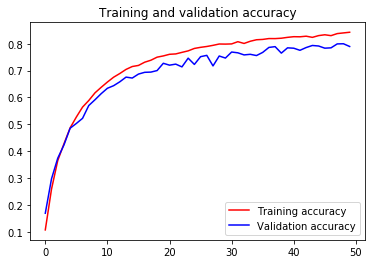

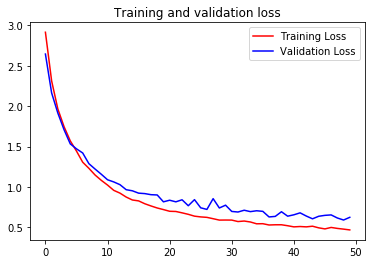

In [25]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()